In [1]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%env KMP_DUPLICATE_LIB_OK=TRUE # fixed my kernel dead

env: KMP_DUPLICATE_LIB_OK=TRUE


In [4]:
words = open("names.txt", 'r').read().split()

In [5]:
len(words)

32033

In [6]:
# characters mapping to/from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [7]:
# build data set with mini batch
random.seed(49)
random.shuffle(words)

block_size = 3 # context length: how many previous characters do we take to predict the next char?
X, y = [], []

for w in words:
    context = [0] * block_size
    chrs = list(w) + ['.']
    for ch in chrs:
        ix = stoi[ch]
        X.append(context)
        y.append(ix)
        # print(  ''.join(itos[i] for i in context) + '--->' + itos[ix] )
        context = context[1:] + [ix]

X = torch.tensor(X)
y = torch.tensor(y)

n1 = int(len(X)*0.8)
n2 = int(len(X)*0.9)

X_train, y_train = X[:n1], y[:n1]
X_val, y_val = X[n1:n2], y[n1:n2]
X_test, y_test = X[n2:], y[n2:]

In [8]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([182516, 3]) torch.Size([182516])
torch.Size([22815, 3]) torch.Size([22815])
torch.Size([22815, 3]) torch.Size([22815])


# Build MLP

In [75]:
g = torch.Generator().manual_seed(49)

C = torch.randn(27, 2, generator=g)
w1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
w2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

In [76]:
num_params = sum(p.nelement() for p in parameters)
print(f"total parameters: {num_params}")

total parameters: 3481


In [77]:
# set gradient tracking 
for p in parameters:
    p.requires_grad = True
    
lr = 1e-1
batch_size = 32 
epochs = 15000

In [78]:
step_i = []
loss_i = []
lr_i = []

for i in range(epochs):
    # mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))

    # forward pass
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

    #backward pass
    for p in parameters:
        p.grad = None # set zero grad

    loss.backward() # backward 
    
    if i >= 10000: lr = 1e-2
    for p in parameters:
        p.data += -lr * p.grad # update step
        
    # track stats
    step_i.append(i)
    loss_i.append(loss.item())
    lr_i.append(lr)
    
    if i % 1000 == 0:
        print(f'loss: {loss.item():.4f}')
        

loss: 13.6378
loss: 2.4653
loss: 2.7931
loss: 3.1618
loss: 2.6209
loss: 2.5875
loss: 2.5333
loss: 2.3435
loss: 2.7820
loss: 2.6318
loss: 2.4727
loss: 2.1529
loss: 2.1890
loss: 2.6316
loss: 2.3932


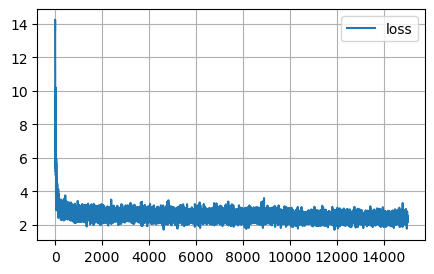

In [79]:
plt.figure(figsize=(5,3))
plt.plot(step_i, loss_i)
plt.legend(['loss'])
plt.grid();

In [80]:
# Validation
emb = C[X_val]
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.3989, grad_fn=<NllLossBackward0>)

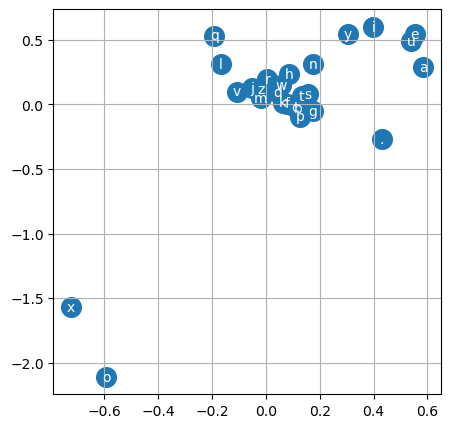

In [82]:
# visualize dimensions of matrix embedding C for all characters
plt.figure(figsize=(5,5))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid();

# Define learning rate

In [28]:
lre = torch.linspace(-3, 0, epochs)
lrs = 10**lre

In [29]:
lr_i = []
lre_i = []
loss_i = []

for i in range(epochs):
    # mini-batch
    ix = torch.randint(0, X_train.shape[0], (32, ))

    # forward pass
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

    #backward pass
    for p in parameters:
        p.grad = None # set zero grad

    loss.backward() # backward 
    
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad # update step
        
    if i % 1000 == 0:
        print(f'loss: {loss.item():.4f}')
        
    # track stats
    lr_i.append(lr.item())
    lre_i.append(lre[i].item())
    loss_i.append(loss.item())

loss: 13.6689


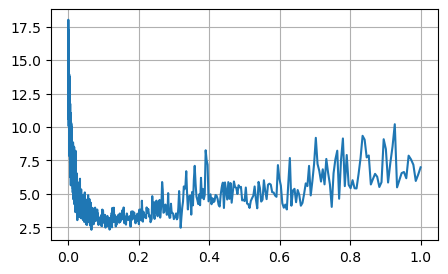

In [32]:
plt.figure(figsize=(5,3))
plt.plot(lr_i, loss_i)
plt.grid();

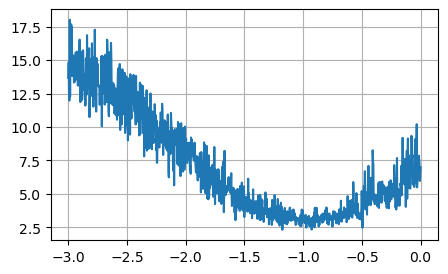

In [33]:
plt.figure(figsize=(5,3))
plt.plot(lre_i, loss_i)
plt.grid();
# learning rate somewhere around 1e-1 

# Inference/Predict

In [42]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    # forward pass
    context = [0] * block_size
    name = []

    while True:
        x = torch.tensor([context])
        emb = C[x]
        h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        ch = itos[ix]
        name.append(ch)

        if ix == 0:
            break

    print(''.join(name))

junide.
canasah.
alasay.
acina.
siinlto.
caas.
tez.
asahnaa.
yanilenhas.
dbyainr.
